# 📊 A/B Test Analysis – Conversion & Retention

This notebook analyzes a simulated A/B test for a product feature launch using conversion and retention metrics. It includes:
- Group-wise rate comparisons
- Statistical significance tests (p-values, confidence intervals)
- Visualizations of treatment lift


In [1]:
import sys
print(sys.executable)

/Library/Frameworks/Python.framework/Versions/3.13/bin/python3.13


In [2]:
!/Library/Frameworks/Python.framework/Versions/3.13/bin/python3.13 -m pip install matplotlib seaborn statsmodels

  Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached statsmodels-0.14.4-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_universal2.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached statsmodels-0.14.4-cp313-cp313-macosx_11_0_arm64.whl (9.9 MB)
Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-a

In [ ]:
!pip install matplotlib seaborn statsmodels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

# Load the dataset
df = pd.read_csv("ab_test_dataset.csv")
df.head()

,user_id,group,converted,retained,timestamp
0,1,control,0,1,2024-12-01 00:00:00
1,2,treatment,1,0,2024-12-01 01:00:00
2,3,control,0,0,2024-12-01 02:00:00
3,4,control,0,1,2024-12-01 03:00:00
4,5,control,1,1,2024-12-01 04:00:00


## 📈 Group-Level Conversion & Retention Rates

In [4]:
summary = df.groupby("group").agg(
    conversion_rate=("converted", "mean"),
    retention_rate=("retained", "mean"),
    users=("user_id", "count")
).reset_index()
summary

,group,conversion_rate,retention_rate,users
0,control,0.177551,0.422449,490
1,treatment,0.225490,0.494118,510


## 📉 Statistical Significance – Z-tests and Confidence Intervals

In [5]:
# Conversion test
conv_success = df.groupby("group")["converted"].sum()
conv_total = df.groupby("group")["converted"].count()
zstat_conv, pval_conv = proportions_ztest(count=conv_success, nobs=conv_total)
confint_conv = confint_proportions_2indep(conv_success["control"], conv_total["control"],
                                          conv_success["treatment"], conv_total["treatment"],
                                          method='wald')

# Retention test
ret_success = df.groupby("group")["retained"].sum()
ret_total = df.groupby("group")["retained"].count()
zstat_ret, pval_ret = proportions_ztest(count=ret_success, nobs=ret_total)
confint_ret = confint_proportions_2indep(ret_success["control"], ret_total["control"],
                                         ret_success["treatment"], ret_total["treatment"],
                                         method='wald')

# Summarize
stats_summary = pd.DataFrame({
    "Metric": ["Conversion Rate", "Retention Rate"],
    "Control Rate": [conv_success["control"]/conv_total["control"],
                     ret_success["control"]/ret_total["control"]],
    "Treatment Rate": [conv_success["treatment"]/conv_total["treatment"],
                       ret_success["treatment"]/ret_total["treatment"]],
    "P-Value": [pval_conv, pval_ret],
    "95% CI Lower": [confint_conv[0], confint_ret[0]],
    "95% CI Upper": [confint_conv[1], confint_ret[1]]
}).round(4)

stats_summary

,Metric,Control Rate,Treatment Rate,P-Value,95% CI Lower,95% CI Upper
0,Conversion Rate,0.1776,0.2255,0.0591,-0.0975,0.0017
1,Retention Rate,0.4224,0.4941,0.0230,-0.1333,-0.0101


## 📊 Visualize Treatment Rates with 95% Confidence Intervals

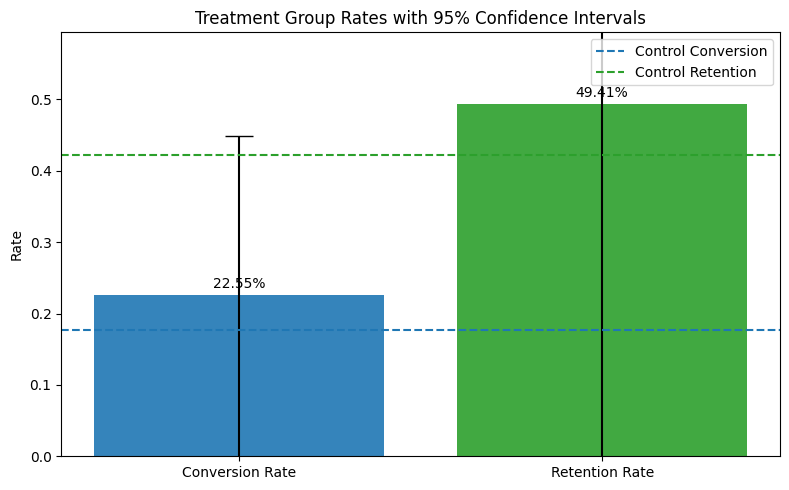

In [6]:
metrics = ["Conversion Rate", "Retention Rate"]
ci_errors_lower = abs(stats_summary["Treatment Rate"] - stats_summary["95% CI Lower"])
ci_errors_upper = abs(stats_summary["95% CI Upper"] - stats_summary["Treatment Rate"])
error_bars = [ci_errors_lower.values, ci_errors_upper.values]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(metrics, stats_summary["Treatment Rate"], yerr=error_bars, capsize=10,
       color=["#1f77b4", "#2ca02c"], alpha=0.9)

ax.axhline(stats_summary["Control Rate"].iloc[0], linestyle="--", color="#1f77b4", label="Control Conversion")
ax.axhline(stats_summary["Control Rate"].iloc[1], linestyle="--", color="#2ca02c", label="Control Retention")

for i, val in enumerate(stats_summary["Treatment Rate"]):
    ax.text(i, val + 0.01, f"{val:.2%}", ha='center', fontsize=10)

ax.set_title("Treatment Group Rates with 95% Confidence Intervals")
ax.set_ylabel("Rate")
ax.set_ylim(0, max(stats_summary["Treatment Rate"]) + 0.1)
ax.legend()
plt.tight_layout()
plt.show()